# EDA & Baseline Modeling (Norway 2025)

### What this notebook does
- Loads the polls table from `../data/processed/polls.sqlite`.
- Exploratory checks: coverage, date range, distributions.
- Simple feature engineering (lags and rolling means).
- Baseline regression (Ridge) per party to predict percent support.
- Evaluates MAE on a small time-based holdout.
- Simulates block-majority probabilities (Left vs Right) using residual noise.
- Saves quick artifacts for downstream use.


In [1]:
import sqlite3, math, json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

print("pandas", pd.__version__)
print("numpy", np.__version__)


pandas 2.2.3
numpy 2.2.6


### Why these imports
- `sklearn.linear_model.Ridge`: simple, stable baseline regression.
- `Pipeline` + `StandardScaler` keeps preprocessing inside the model.
- `mean_absolute_error` is easy to interpret in percentage points.


In [2]:
ROOT = Path.cwd().resolve()
DB_PATH = (ROOT / "../data/processed/polls.sqlite").resolve()

conn = sqlite3.connect(DB_PATH)
df = pd.read_sql("SELECT * FROM polls ORDER BY date", conn)
conn.close()

df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.sort_values('date').reset_index(drop=True)

party_cols = [c for c in ["ap","h","frp","sp","sv","krf","v","mdg","r","p","dem"] if c in df.columns]
df = df[['pollster','date', *party_cols]]
df.head()


,pollster,date,ap,h,frp,sp,sv,krf,v,mdg,r
0,pollofpolls_avg,2025-01-31,19.0,21.7,24.4,6.2,8.1,3.4,4.5,3.3,5.4
1,pollofpolls_avg,2025-02-28,24.8,18.4,24.6,6.6,7.4,3.0,4.2,2.4,5.4
2,pollofpolls_avg,2025-03-31,28.1,18.8,22.7,4.9,7.2,3.1,4.3,2.7,4.6
3,pollofpolls_avg,2025-04-30,28.1,19.8,20.0,6.7,6.3,3.3,3.9,3.1,4.8
4,pollofpolls_avg,2025-05-31,28.5,18.7,20.6,5.7,7.0,3.6,4.1,2.7,5.3


### Load & trim
- Reads the `polls` table ordered by date.
- Restricts to known party columns for consistency across runs.


In [3]:
eda = {
    "n_rows": len(df),
    "date_min": df['date'].min(),
    "date_max": df['date'].max(),
    "parties": party_cols,
}
eda


{'n_rows': 20,
 'date_min': Timestamp('2025-01-31 00:00:00'),
 'date_max': Timestamp('2025-09-24 00:00:00'),
 'parties': ['ap', 'h', 'frp', 'sp', 'sv', 'krf', 'v', 'mdg', 'r']}

### EDA summary
- Confirms how many polls we have and the covered time range.
- Lists which parties are present (varies by data source).


In [4]:
# Basic distribution stats
stats = df[party_cols].describe().T
stats


,count,mean,std,min,25%,50%,75%,max
ap,20.0,22.845,3.673443,19.0,20.150,20.85,27.625,28.5
h,20.0,22.935,4.489083,14.8,18.775,25.60,26.500,27.2
frp,20.0,16.115,5.092748,11.7,12.075,12.45,21.125,24.6
sp,20.0,6.235,0.448712,4.9,6.075,6.30,6.525,6.8
sv,20.0,7.065,0.481527,6.3,6.775,7.00,7.225,8.2
krf,20.0,3.495,0.281864,3.0,3.400,3.50,3.600,4.4
v,20.0,4.550,0.254434,3.9,4.500,4.60,4.700,4.9
mdg,20.0,4.260,1.055512,2.4,3.250,4.90,5.100,5.3
r,20.0,5.650,0.414856,4.6,5.400,5.75,5.925,6.2


### Party distributions
- Quick descriptive stats to spot outliers or unrealistic values.


In [5]:
# Add an integer time index and simple lags/rolling features
df_feat = df.copy()
df_feat['t'] = np.arange(len(df_feat))

def add_lags(frame, cols, lags=(1,2,3)):
    out = frame.copy()
    for c in cols:
        for L in lags:
            out[f"{c}_lag{L}"] = out[c].shift(L)
    return out

def add_roll_means(frame, cols, windows=(3,5)):
    out = frame.copy()
    for c in cols:
        for w in windows:
            out[f"{c}_roll{w}"] = out[c].rolling(window=w, min_periods=1).mean()
    return out

df_feat = add_lags(df_feat, party_cols, lags=(1,2,3))
df_feat = add_roll_means(df_feat, party_cols, windows=(3,5))

# Drop first few rows without full lag info
min_lag = 3
df_feat = df_feat.iloc[min_lag:].reset_index(drop=True)
df_feat.head()


,pollster,date,ap,h,frp,sp,sv,krf,v,mdg,...,sv_roll3,sv_roll5,krf_roll3,krf_roll5,v_roll3,v_roll5,mdg_roll3,mdg_roll5,r_roll3,r_roll5
0,pollofpolls_avg,2025-04-30,28.1,19.8,20.0,6.7,6.3,3.3,3.9,3.1,...,6.966667,7.25,3.133333,3.20,4.133333,4.225,2.733333,2.875,4.933333,5.05
1,pollofpolls_avg,2025-05-31,28.5,18.7,20.6,5.7,7.0,3.6,4.1,2.7,...,6.833333,7.20,3.333333,3.28,4.100000,4.200,2.833333,2.840,4.900000,5.10
2,pollofpolls_avg,2025-06-30,28.3,16.2,21.0,5.6,6.9,3.7,4.5,3.0,...,6.733333,6.96,3.533333,3.34,4.166667,4.200,2.933333,2.780,5.433333,5.26
3,pollofpolls_avg,2025-07-31,27.7,14.8,21.5,6.3,8.2,3.2,4.7,3.5,...,7.366667,7.12,3.500000,3.38,4.433333,4.300,3.066667,3.000,5.800000,5.36
4,Norfakta,2025-08-01,20.5,26.0,12.5,6.5,7.0,3.5,4.5,5.0,...,7.366667,7.08,3.466667,3.46,4.566667,4.340,3.833333,3.460,6.033333,5.64


### Feature engineering
- Adds a simple time index `t`.
- For each party: creates 1/2/3-lag features.
- Adds rolling means (3 and 5 polls) as smoothed signals.
- Drops the first rows where lags are undefined.


In [6]:
# Hold out the last K polls for testing (time-aware split)
K_TEST = min(3, len(df_feat)//3) if len(df_feat) > 6 else max(1, len(df_feat)//4)
split_idx = len(df_feat) - K_TEST

train = df_feat.iloc[:split_idx].copy()
test  = df_feat.iloc[split_idx:].copy()

X_cols = ['t'] +          [c for c in df_feat.columns if any(s in c for s in ['_lag','_roll']) and any(p in c for p in party_cols)]

X_train, X_test = train[X_cols].values, test[X_cols].values

len(train), len(test), X_train.shape, X_test.shape


(14, 3, (14, 46), (3, 46))

### Time-aware split
- Uses the last `K_TEST` polls as the test set to mimic forecasting.
- Input features: time index + all lag/rolling features.


In [7]:
models = {}
y_train, y_test = {}, {}
yhat_train, yhat_test = {}, {}

for p in party_cols:
    y_train[p] = train[p].values
    y_test[p]  = test[p].values

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('ridge', Ridge(alpha=2.0, random_state=0))
    ])
    pipe.fit(X_train, y_train[p])
    models[p] = pipe

    yhat_train[p] = pipe.predict(X_train)
    yhat_test[p]  = pipe.predict(X_test)

# Collect metrics
rows = []
for p in party_cols:
    mae_tr = mean_absolute_error(y_train[p], yhat_train[p])
    mae_te = mean_absolute_error(y_test[p], yhat_test[p]) if len(y_test[p])>0 else np.nan
    rows.append({"party": p, "mae_train": mae_tr, "mae_test": mae_te})
metrics = pd.DataFrame(rows).sort_values("party").reset_index(drop=True)
metrics


,party,mae_train,mae_test
0,ap,0.342594,1.122464
1,frp,0.369247,0.980170
2,h,0.522593,1.270899
3,krf,0.053680,0.188574
4,mdg,0.074160,0.277775
5,r,0.030086,0.228344
6,sp,0.049392,0.228203
7,sv,0.041924,0.170952
8,v,0.020188,0.119182


### Baseline Ridge per party
- Trains a separate Ridge regression for each party.
- Reports MAE on train and test. With few polls, test MAE will be noisy — still useful as a sanity check.


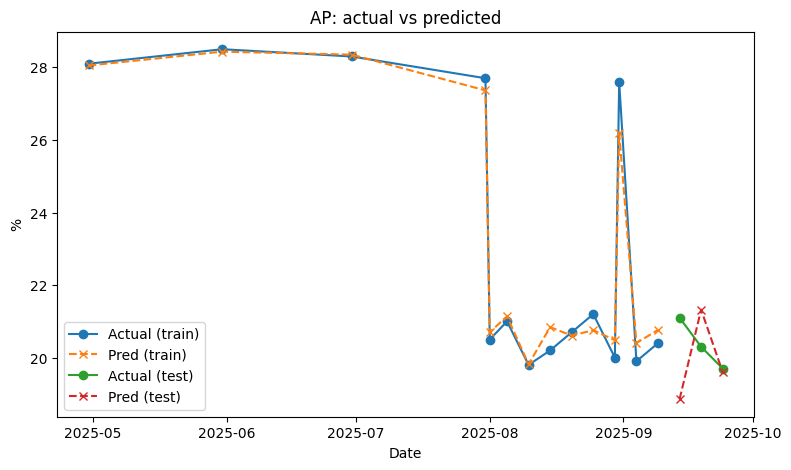

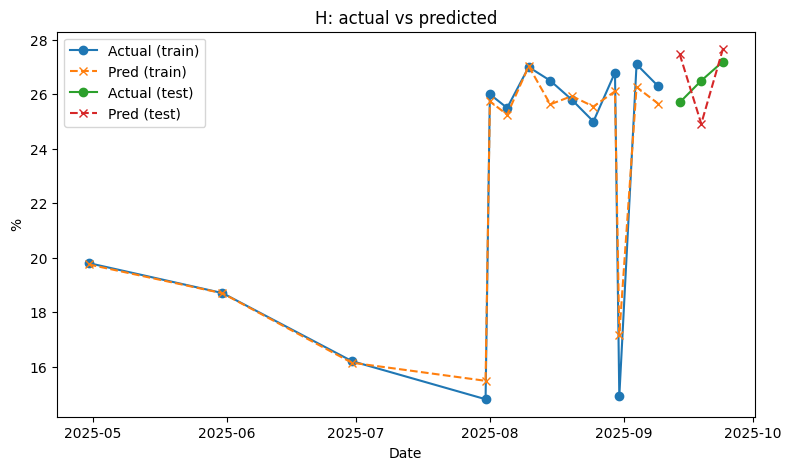

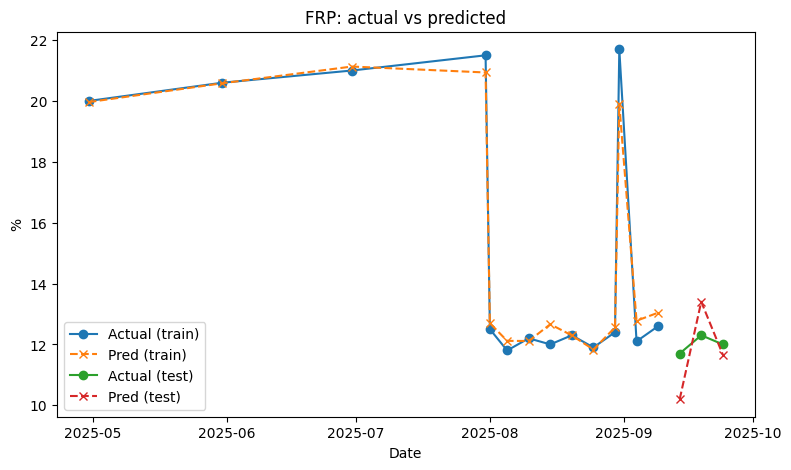

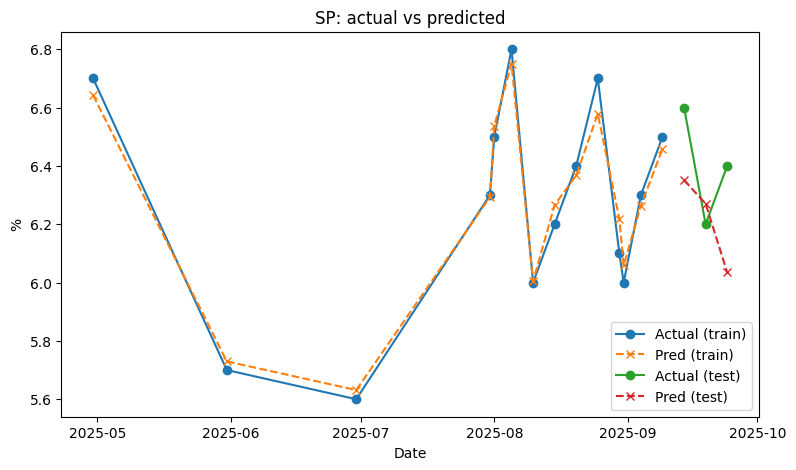

In [8]:
def plot_party(p):
    plt.figure(figsize=(9,5))
    # In-sample
    plt.plot(train['date'], y_train[p], marker='o', label='Actual (train)')
    plt.plot(train['date'], yhat_train[p], marker='x', linestyle='--', label='Pred (train)')
    # Out-of-sample
    if len(test)>0:
        plt.plot(test['date'], y_test[p], marker='o', label='Actual (test)')
        plt.plot(test['date'], yhat_test[p], marker='x', linestyle='--', label='Pred (test)')
    plt.title(f"{p.upper()}: actual vs predicted")
    plt.ylabel("%"); plt.xlabel("Date"); plt.legend()
    plt.show()

for p in [c for c in ["ap","h","frp","sp"] if c in party_cols]:
    plot_party(p)


### Visual check of fit
- For AP, H, FRP, SP (if present): compare actual vs predicted over time.
- Look for systematic bias or large misses near the end (where it matters most).


In [9]:
# Estimate per-party residual std from train fit
resid_std = {}
for p in party_cols:
    resid = y_train[p] - yhat_train[p]
    resid_std[p] = float(np.nanstd(resid, ddof=1)) if len(resid) > 1 else 2.0  # fallback

resid_std


{'ap': 0.5122370425653635,
 'h': 0.8035902549379086,
 'frp': 0.6116149255547711,
 'sp': 0.06190218720248351,
 'sv': 0.05391242707166022,
 'krf': 0.07264902766429339,
 'v': 0.02573635114058131,
 'mdg': 0.10711841598921872,
 'r': 0.0396097676284324}

### Residual-based uncertainty
- Uses the standard deviation of training residuals as a proxy for forecast noise.
- This is simplistic but gives us a way to simulate block uncertainty.


In [10]:
left_block = {"ap","sv","sp","mdg","r"}
right_block = {"h","frp","krf","v"}

# Choose the last available predicted point as "current" forecast
if len(test) > 0:
    base_row = test.iloc[-1]
    x_base = base_row[X_cols].values.reshape(1,-1)
else:
    base_row = train.iloc[-1]
    x_base = base_row[X_cols].values.reshape(1,-1)

pred_point = {}
for p in party_cols:
    pred_point[p] = float(models[p].predict(x_base)[0])

# Monte Carlo
N = 10000
rng = np.random.default_rng(0)
left_tot = np.zeros(N)
right_tot = np.zeros(N)

for i in range(N):
    s_left = 0.0
    s_right = 0.0
    for p in party_cols:
        mu = pred_point[p]
        sd = resid_std.get(p, 2.0)
        draw = rng.normal(mu, sd)
        if p in left_block:
            s_left += max(0.0, draw)
        if p in right_block:
            s_right += max(0.0, draw)
    left_tot[i] = s_left
    right_tot[i] = s_right

prob_left = float(np.mean(left_tot >= 50.0))
prob_right = float(np.mean(right_tot >= 50.0))

summary = {
    "pred_point": {k: round(v,2) for k,v in pred_point.items()},
    "prob_left_majority": round(prob_left,3),
    "prob_right_majority": round(prob_right,3),
}
summary


{'pred_point': {'ap': 19.6,
  'h': 27.66,
  'frp': 11.66,
  'sp': 6.03,
  'sv': 6.87,
  'krf': 3.53,
  'v': 4.66,
  'mdg': 5.21,
  'r': 5.93},
 'prob_left_majority': 0.0,
 'prob_right_majority': 0.007}

### Simulated block-majority probabilities
- Takes the latest prediction point and simulates many draws per party using residual std as noise.
- Aggregates into left/right blocks and computes the share of simulations crossing 50%.
- This is **not** a seat model — it’s a quick probability sketch based on vote shares.


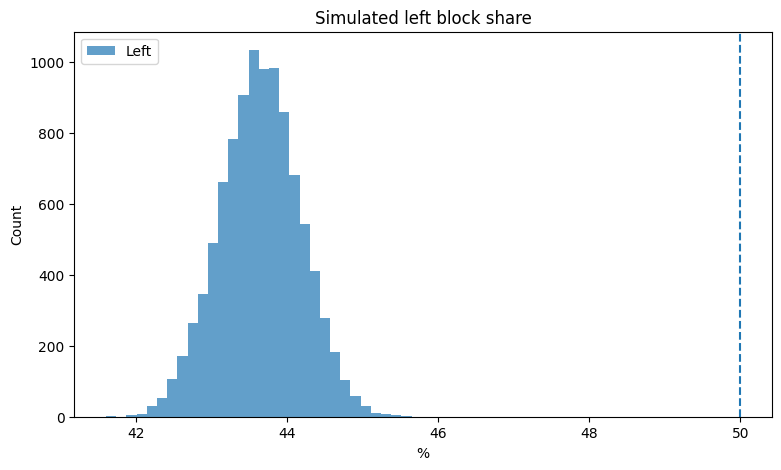

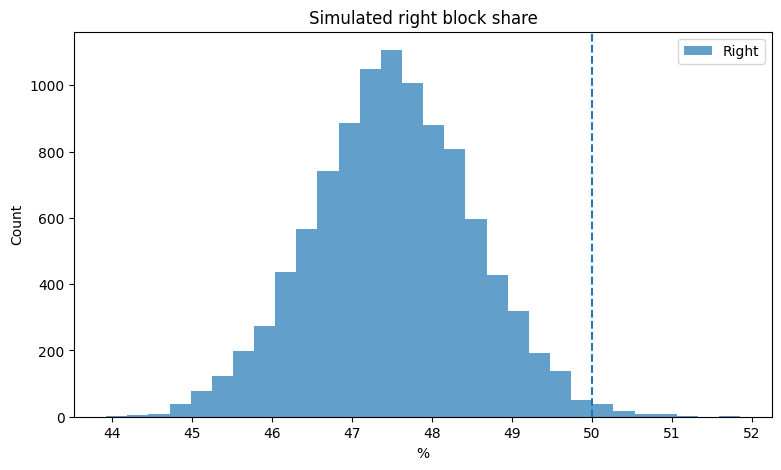

In [11]:
plt.figure(figsize=(9,5))
plt.hist(left_tot, bins=30, alpha=0.7, label='Left')
plt.axvline(50, linestyle='--')
plt.title("Simulated left block share")
plt.xlabel("%"); plt.ylabel("Count"); plt.legend()
plt.show()

plt.figure(figsize=(9,5))
plt.hist(right_tot, bins=30, alpha=0.7, label='Right')
plt.axvline(50, linestyle='--')
plt.title("Simulated right block share")
plt.xlabel("%"); plt.ylabel("Count"); plt.legend()
plt.show()


### Uncertainty visualization
- Histograms show how often the simulated block total falls above/below 50%.
- Wide histograms mean higher uncertainty (few polls, noisy signals).


In [12]:
ART_DIR = (ROOT / "../data/processed").resolve()
ART_DIR.mkdir(parents=True, exist_ok=True)

# Save metrics and residual std for reproducibility
metrics_path = ART_DIR / "model_metrics.csv"
metrics.to_csv(metrics_path, index=False)

resid_path = ART_DIR / "residual_std.json"
with open(resid_path, "w") as f:
    json.dump(resid_std, f, indent=2)

metrics_path.as_posix(), resid_path.as_posix()


('/workspaces/Norway-2025-polls/data/processed/model_metrics.csv',
 '/workspaces/Norway-2025-polls/data/processed/residual_std.json')

### Artifacts
- Saves `model_metrics.csv` (per-party MAE) and `residual_std.json` (per-party noise estimates).
- These are handy for dashboards or pipeline monitoring.


## Next steps
- Add seat allocation (e.g., Sainte-Laguë) to translate votes → seats.
- Weight polls by recency and sample size; handle house effects.
- Use a hierarchical or state-space model for smoother trends.
- Calibrate residual noise vs actual backtests once we have more polls.
